In [1]:
from sae_lens import HookedSAETransformer
import torch
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict
import time
import json

In [2]:
def get_inputs(tok, n_texts, max_length=1024):
    data = datasets.load_dataset('NeelNanda/pile-10k')['train']
    texts = []

    for i, t in enumerate(data):
        if len(t['text']) > 4000:
            tok_text = tok(t['text'], padding=False, truncation=True, return_tensors='pt', max_length=max_length)
            if tok_text.input_ids.shape[1] == max_length:
                texts.append(t['text'])

        if len(texts) == n_texts:
            break
    
    if len(texts) < n_texts:
        raise ValueError('not enough texts, only found', len(texts))


    print('went through', i, 'texts')

    input = tok(texts, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    assert torch.all(input.attention_mask == 1)
    return input

def generate_unigrams(transformer, layer, hook_name, all_tokens, t_fn, device, batch_size=32):
    all_tokens = list(all_tokens)

    sequences = [t_fn(t) for t in all_tokens]

    t_acts = None
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        ids = torch.tensor(batch, device=device)

        _, activations = transformer.run_with_cache(ids, prepend_bos=False, stop_at_layer=layer)
        activations = activations[hook_name]
        if t_acts is None:
            t_acts = activations[:, -1, :].to('cpu')
        else:
            t_acts = torch.concat((t_acts, activations[:, -1, :].to('cpu')), dim=0)

    act_dict = {}

    for i, act in enumerate(t_acts):
        act_dict[all_tokens[i]] = act

    return act_dict
    
def get_correlations(sequence_acts, input_ids, token_dict, device):
    unigram_acts = torch.empty_like(sequence_acts)

    for i, id in enumerate(input_ids):
        unigram_act = token_dict[int(id)].to(device)
        unigram_acts[i] = unigram_act


    return cosine_similarity(sequence_acts, unigram_acts, dim=-1).cpu().numpy().tolist()


def get_sequence_activations(transformer, layer, hook_name, input, full_sequence_batch_size, device):
    sequence_acts = []

    with torch.no_grad():
        for i in range(0, input.input_ids.shape[0], full_sequence_batch_size):
            batch = input.input_ids[i:i+full_sequence_batch_size].to(device)
            acts = transformer.run_with_cache(batch, prepend_bos=False, stop_at_layer=layer)[1][hook_name]

            for j in range(batch.shape[0]):
                sequence_acts.append(acts[j])

    return sequence_acts


def all_unigrams(transformer, layer, hook_name, all_tokens, token_sequence_batch_size, device):
    store = {}

    with torch.no_grad():
        store['bos'] = generate_unigrams(transformer,    layer, hook_name, all_tokens, lambda t: [transformer.tokenizer.bos_token_id, t], device, batch_size=token_sequence_batch_size)
        store['repeat'] = generate_unigrams(transformer, layer, hook_name, all_tokens, lambda t: [t, t], device, batch_size=token_sequence_batch_size)
        store['space'] = generate_unigrams(transformer,  layer, hook_name, all_tokens, lambda t: [220, t],  device, batch_size=token_sequence_batch_size)
        store['newline'] = generate_unigrams(transformer, layer, hook_name, all_tokens, lambda t: [198, t],  device, batch_size=token_sequence_batch_size)
        store['space2'] = generate_unigrams(transformer, layer, hook_name, all_tokens, lambda t: [220, 220, t],  device, batch_size=token_sequence_batch_size)
        store['rand'] = generate_unigrams(transformer,   layer, hook_name, all_tokens, lambda t: [37233, t],  device, batch_size=token_sequence_batch_size)

    return store

def layer_correlations(transformer, layer, hook_name, sequence_ids, full_sequence_batch_size, token_sequence_batch_size, device):
    start = time.time()
    n_texts = sequence_ids.input_ids.shape[0]
    sequence_acts = get_sequence_activations(transformer, layer, hook_name, sequence_ids, full_sequence_batch_size, device)

    print('generated sequence activations in', time.time() - start)

    all_tokens = set()
    for i in range(n_texts):
        all_tokens.update(sequence_ids.input_ids[i].tolist())


    unigrams = all_unigrams(transformer, layer, hook_name, all_tokens, token_sequence_batch_size, device)

    print('generated unigrams in', time.time() - start)

    corrs = defaultdict(list)
    for i in range(n_texts):
        text_activations = sequence_acts[i].squeeze()
        text_ids = sequence_ids.input_ids[i]

        for k, token_dict in unigrams.items():
            corrs[k].append(get_correlations(text_activations, text_ids, token_dict, device))

    print('generated correlations in', time.time() - start)

    return corrs

In [3]:
device='cuda'
transformer_name = 'gpt2-small'
n_texts = 1000

full_sequence_batch_size = 2
token_sequence_batch_size = 512

In [4]:
transformer = HookedSAETransformer.from_pretrained(transformer_name, device=device)
tok = transformer.tokenizer
input = get_inputs(tok, n_texts)

Loaded pretrained model gpt2-small into HookedTransformer
went through 4500 texts


In [5]:
for layer in range(11, -1, -1):
    hook_name = f'blocks.{layer}.hook_resid_pre'
    next_layer=layer + 1

    corrs = layer_correlations(transformer, next_layer, hook_name, input, full_sequence_batch_size, token_sequence_batch_size, device)

    with open(f'../cruft/layer_{layer}_corrs-1000.json', 'w') as f:
        json.dump(corrs, f)

generated sequence activations in 100.38765740394592
generated unigrams in 138.26116132736206
generated correlations in 326.99670791625977
generated sequence activations in 92.08586072921753
generated unigrams in 127.92910408973694
generated correlations in 316.7129714488983
generated sequence activations in 84.49321460723877
generated unigrams in 118.22750091552734
generated correlations in 307.91590571403503
generated sequence activations in 76.37716865539551
generated unigrams in 107.42821478843689
generated correlations in 296.7245614528656
generated sequence activations in 68.43178725242615
generated unigrams in 97.18915224075317


bos torch.Size([1024]) tensor(0.6035) tensor(0.0497)
repeat torch.Size([1024]) tensor(0.6241) tensor(0.0482)
space torch.Size([1024]) tensor(0.6256) tensor(0.0477)
newline torch.Size([1024]) tensor(0.6152) tensor(0.0487)
space2 torch.Size([1024]) tensor(0.6198) tensor(0.0475)
rand torch.Size([1024]) tensor(0.6052) tensor(0.0498)


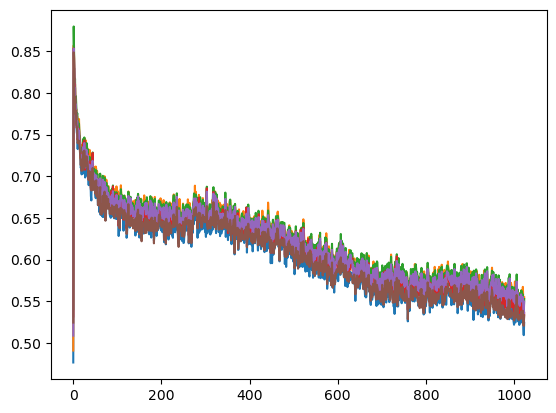

In [70]:
for k, token_dict in corrs.items():
    s = torch.stack(token_dict).mean(dim=0)
    print(k, s.shape, s.mean(), s.std())
    plt.plot(s, label=k)

bos torch.Size([1024]) tensor(0.6035) tensor(0.0497)
repeat torch.Size([1024]) tensor(0.6241) tensor(0.0482)
space torch.Size([1024]) tensor(0.6256) tensor(0.0477)
newline torch.Size([1024]) tensor(0.6152) tensor(0.0487)
space2 torch.Size([1024]) tensor(0.6198) tensor(0.0475)
rand torch.Size([1024]) tensor(0.6052) tensor(0.0498)


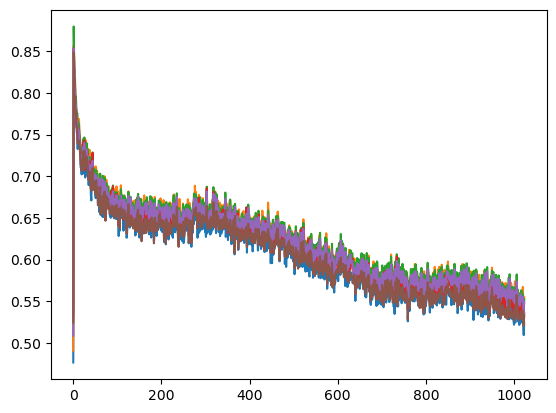

In [58]:
for k, token_dict in corrs.items():
    s = torch.stack(token_dict).mean(dim=0)
    print(k, s.shape, s.mean(), s.std())
    plt.plot(s, label=k)